## The goal of this notebook is to train a model on a simulated dataset (TNG50) with morphology labels and adapt that model to run on real data (DESI observations).

> #### 1. Import the necessary libraries

In [3]:
from pathlib import Path
import os, random
from tqdm import tqdm

import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data import random_split

def set_all_seeds(seed=42):

    os.environ["PYTHONHASHSEED"] = str(seed)  # For Python's hash seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Optional: enforce deterministic algorithms where possible
    torch.use_deterministic_algorithms(True, warn_only=True)
set_all_seeds()

> #### 2. Save the paths to the image and label folders

In [23]:
# Add paths to all the relevant datasets and images
# Download images according to the README
HOME = Path("../data")
source_dataset_images = HOME / "source/galaxy_images_rgb"
source_dataset_labels = HOME / "source/galaxy_labels.csv"
target_dataset_images= HOME / "target/gz_desi"
target_dataset_labels= HOME / "target/gz_desi_labels.csv"

> #### 3. Print both the datasets using pandas to have a better view of the data in both of them

> ##### For the source dataset

In [5]:
df_source = pd.read_csv(source_dataset_labels)
df_source.head()

,subhalo_id,mass,star_forming,has_agn,is_compact,metallicity,classification,is_metalrich
0,0,3.682930e+12,False,False,True,0.035705,elliptical,1
1,1,2.673136e+11,False,False,True,0.034155,spiral,1
2,2,1.302537e+11,False,False,True,0.028685,elliptical,1
3,8,2.528330e+10,True,True,True,0.023264,spiral,1
4,11,2.539410e+10,True,False,False,0.021454,spiral,1


> ##### For the target dataset

In [6]:
df_target = pd.read_csv(target_dataset_labels)
df_target.head()

,subhalo_id,dataset_name,ra,dec,classification
0,31735_172.png,gz_desi,68.185032,-64.865396,spiral
1,348398_4061.png,gz_desi,187.567874,3.072957,spiral
2,441607_3986.png,gz_desi,244.032731,19.569928,elliptical
3,331882_4124.png,gz_desi,18.682824,0.286017,spiral
4,471791_4207.png,gz_desi,114.086487,25.305936,elliptical


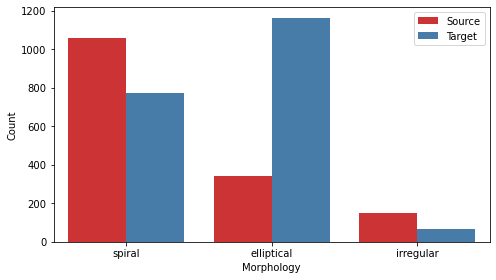

In [24]:
# Visualizing the different distributions of classes

df_source_ = df_source.copy()
df_target_ = df_target.copy()
df_source_["domain"] = "Source"
df_target_["domain"] = "Target"

# Combine and pick a consistent class order across both sets
df_both = pd.concat([df_source_, df_target_[0:2000]], ignore_index=True)
order = df_both["classification"].value_counts().index  # order by total count (combined)

plt.figure(figsize=(7, 4))
sns.countplot(
    data=df_both,
    x="classification",
    order=order,
    hue="domain",       
    palette="Set1"        
)
plt.xlabel("Morphology")
plt.ylabel("Count")
plt.legend(title="")
plt.tight_layout()
plt.show()

> #### 4. Now we model the data

> ##### 4.1 For the source dataset

In [8]:
# Modeling

batch_size = 32
images_size = (64, 64)

def give_labels():
    CLASSES = ["elliptical", "irregular", "spiral"] 
    label2idx = {c:i for i,c in enumerate(CLASSES)}
    idx2label = {i:c for c,i in label2idx.items()}
    
    return label2idx, idx2label

# ======For source Dataset class ======
class GalaxyDataset_source(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, include_rotations=True):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.rotations = [0, 90, 180, 270]
        self.include_rotations = include_rotations

        # Map string labels to integers
        self.label2idx, self.idx2label = give_labels()
        self.df["label"] = self.df["classification"].str.strip().str.lower().map(self.label2idx)

    def __len__(self):
        if self.include_rotations:
          length = len(self.df) * 8  # 4 rotations * 2 flips
        else:
          length = len(self.df)

        return length

    def __getitem__(self, idx):
        if self.include_rotations:
          base_idx = idx // 8
          aug_idx = idx % 8

          row = self.df.iloc[base_idx]
          img_path = self.img_dir / f"subhalo_{row['subhalo_id']}.png"
          label = int(row["label"])
          image = Image.open(img_path).convert("RGB")

          rotation = self.rotations[aug_idx % 4]
          flip = (aug_idx // 4) == 1

          image = image.rotate(rotation)
          if flip:
              image = image.transpose(Image.FLIP_LEFT_RIGHT)
        else:
          row = self.df.iloc[idx]
          img_path = self.img_dir / f"subhalo_{row['subhalo_id']}.png"

          image = Image.open(img_path).convert("RGB")
          label = int(row["label"])

        if self.transform:
            image = self.transform(image)

        return image, label

label2idx, idx2label = give_labels()
elliptical_idx = label2idx["elliptical"]

num_classes = len(label2idx)
class_weights = torch.ones(num_classes)
class_weights[elliptical_idx] = 3.0 

> ##### 4.2 For the target dataset


In [9]:
# ======For target Dataset class ======
from pathlib import Path

class GalaxyDataset_target(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = Path(img_dir)
        self.transform = transform

        # Map string labels to integers
        self.label2idx, self.idx2label = give_labels()
        self.df["label"] = self.df["classification"].str.strip().str.lower().map(self.label2idx)


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
      row = self.df.iloc[idx]
      img_path = self.img_dir / row["subhalo_id"]

      image = Image.open(img_path).convert("RGB")
      label = int(row["label"])

      if self.transform:
        image = self.transform(image)

      return image, label

> #### 5. Compute the dataset mean and std. deviation (σ) for both the datasets so that we can normalize the images

> ##### For the source dataset

In [15]:
# Compute dataset-specific mean and std

init_transform_source = transforms.Compose([
    transforms.Resize(images_size),  # resize each image
    transforms.ToTensor()            # Converts to tensor and scales to [0, 1]
])
raw_dataset_source = GalaxyDataset_source(source_dataset_labels, source_dataset_images, transform=init_transform_source)

loader = DataLoader(raw_dataset_source, batch_size=batch_size, shuffle=False, num_workers=2)

# Initialize accumulators
mean_source = torch.zeros(3)   # For RGB images
sumsq_source = torch.zeros(3)
num_pixels_source = 0

# Loop through dataset and compute stats
for images, _ in tqdm(loader):
    B, C, H, W = images.shape
    num_pixels_source += B * H * W

    mean_source += images.sum(dim=[0, 2, 3])           # sum over batch, height, width
    sumsq_source += (images ** 2).sum(dim=[0, 2, 3])    # sum of squares for std computation

# Final computation of mean and std
mean_source /= num_pixels_source
std_source = torch.sqrt(sumsq_source / num_pixels_source - mean_source ** 2)\

# Print results
print(f"\nSource Dataset mean: {mean_source}")
print(f"Source Dataset std:  {std_source}")


100%|██████████| 388/388 [01:10<00:00,  5.52it/s]


Source Dataset mean: tensor([0.0989, 0.1074, 0.0828])
Source Dataset std:  tensor([0.1939, 0.2041, 0.1765])


> ##### For the target dataset

In [14]:
# Compute dataset-specific mean and std

init_transform_target = transforms.Compose([
    transforms.Resize(images_size),  # Corrected: resize each image to (28, 28)
    transforms.ToTensor()            # Converts to tensor and scales to [0, 1]
])

raw_dataset_target = GalaxyDataset_target(target_dataset_labels, target_dataset_images, transform=init_transform_target)

loader = DataLoader(raw_dataset_target, batch_size=batch_size, shuffle=False, num_workers=2)

# Initialize accumulators
mean_target = torch.zeros(3)   # For RGB images
sumsq_target = torch.zeros(3)
num_pixels_target = 0

# Loop through dataset and compute stats
for images, _ in tqdm(loader):
    B, C, H, W = images.shape
    num_pixels_target += B * H * W

    mean_target += images.sum(dim=[0, 2, 3])           # sum over batch, height, width
    sumsq_target += (images ** 2).sum(dim=[0, 2, 3])    # sum of squares for std computation

# Final computation of mean and std
mean_target /= num_pixels_target
std_target = torch.sqrt(sumsq_target / num_pixels_target - mean_target ** 2)

print(f"\n Target Dataset mean: {mean_target}")
print(f" Target Dataset std:  {std_target}")

100%|██████████| 313/313 [01:14<00:00,  4.19it/s]


 Target Dataset mean: tensor([0.1060, 0.0990, 0.0967])
 Target Dataset std:  tensor([0.0897, 0.0852, 0.0812])


> #### 6. Create the final dataset

> ##### 6.1 For the source dataset

In [16]:
from torchvision.transforms import InterpolationMode

# Now create final dataset with z-score normalization
final_transform_source = transforms.Compose([
    transforms.Resize(images_size, interpolation=InterpolationMode.BILINEAR, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_source.tolist(), std=std_source.tolist())
])

dataset_source = GalaxyDataset_source(source_dataset_labels,source_dataset_images, transform=final_transform_source)
dataloader_source = DataLoader(dataset_source, batch_size=batch_size, shuffle=True, num_workers=1)

# 90% train, 10% test
train_size = int(0.9 * len(dataset_source))
val_size = len(dataset_source) - train_size

g = torch.Generator().manual_seed(42)
train_dataset_source, val_dataset_source = torch.utils.data.random_split(dataset_source, [train_size, val_size], generator=g)

train_loader_source = DataLoader(train_dataset_source, batch_size=batch_size, shuffle=True, num_workers=1)
val_loader_source   = DataLoader(val_dataset_source, batch_size=batch_size, shuffle=False, num_workers=1)

> ##### 6.2 For the target dataset

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset
from torchvision.transforms import InterpolationMode

zoom = 1.4  # to zoom in a little bit on the galaxies
zoomed_size = (int(images_size[0]*zoom), int(images_size[1]*zoom))


final_transform_target = transforms.Compose([
    transforms.Resize(zoomed_size, interpolation=InterpolationMode.BILINEAR, antialias=True),
    transforms.CenterCrop(images_size),  # crops back down → effective zoom-in
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_target.tolist(), std=std_target.tolist()),
])

dataset_target = GalaxyDataset_target(target_dataset_labels, target_dataset_images, transform=final_transform_target)
dataloader_target = DataLoader(dataset_target, batch_size=32, shuffle=True, num_workers=1)

# 90% train, 10% val
y = dataset_target.df["label"].to_numpy()
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_idx, val_idx = next(sss.split(np.zeros(len(y)), y))

train_dataset_target = Subset(dataset_target, train_idx)
val_dataset_target   = Subset(dataset_target,   val_idx)

train_loader_target = DataLoader(train_dataset_target, batch_size=32, shuffle=True, num_workers=1)
val_loader_target   = DataLoader(val_dataset_target, batch_size=32, shuffle=False, num_workers=1)


> ##### A Quick Sanity check

In [18]:
# Sanity check for source data

images_source, labels_source = next(iter(train_loader_source))
print(f"Batch image tensor shape: {images_source.shape}")
print(f"Batch labels: {labels_source}")

# Sanity check for target data

images_target, labels_target = next(iter(train_loader_target))
print(f"Batch image tensor shape: {images_target.shape}")
print(f"Batch labels: {labels_target}")

Batch image tensor shape: torch.Size([32, 3, 64, 64])
Batch labels: tensor([0, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2,
        0, 2, 2, 0, 2, 2, 2, 2])
Batch image tensor shape: torch.Size([32, 3, 64, 64])
Batch labels: tensor([2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 1, 2, 0, 2, 2, 2, 2, 0, 0, 0,
        0, 0, 0, 0, 0, 2, 0, 2])


> #### 7. Plot some images with labels for visualisation

> ##### 7.1 For the source dataset

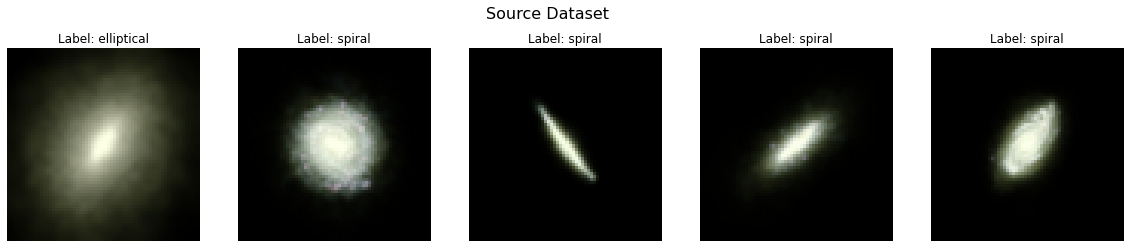

In [19]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    # undo normalization: (x * std) + mean
    img = images_source[i] * std_source[:, None, None] + mean_source[:, None, None]
    img = img.permute(1, 2, 0).clamp(0, 1)  # Convert to HWC and clamp to [0,1]
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {dataset_source.idx2label[labels_source[i].item()]}")
    axes[i].axis("off")

fig.suptitle("Source Dataset", fontsize=16)
plt.show()

> ##### 7.2 For the target dataset

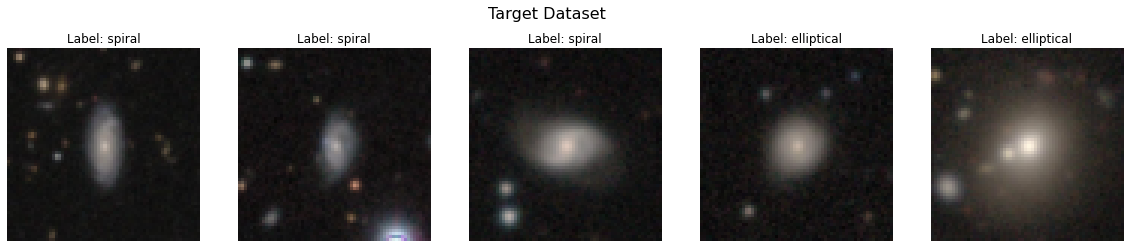

In [20]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    # undo normalization: (x * std) + mean
    img = images_target[i] * std_target[:, None, None] + mean_target[:, None, None]
    img = img.permute(1, 2, 0).clamp(0, 1)  # Convert to HWC and clamp to [0,1]
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {dataset_target.idx2label[labels_target[i].item()]}")
    axes[i].axis("off")

fig.suptitle("Target Dataset", fontsize=16)
plt.show()

> #### 8. Create the model architecture

In [21]:
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes=3, feature_dim=128):
        super().__init__()

        # Convolutional feature extractor (unchanged)
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )

        # Size-agnostic pooling → fixed-length embedding
        self.avgpool = nn.AdaptiveAvgPool2d(1)  # (B, 128, 1, 1) for any HxW
        self.feature_dim = feature_dim          # = 128 after the conv stack

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        fmaps = self.features(x)                # (B, 128, H', W')
        z = torch.flatten(self.avgpool(fmaps), 1)  # (B, 128) regardless of input size
        out = self.classifier(z)
        return out, z


> #### 9. Train the initial, un-adapted model

> #### 9.1 Training on just the source dataset

In [22]:
# === Setup device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# === Initialize model ===
source_model = CNN().to(device) 

# === Label mapping ===
label_map = give_labels()[0]  # Maps class names to integer indices

# === Loss function and optimizer ===
class_weights = torch.as_tensor(class_weights, dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
# criterion = nn.CrossEntropyLoss() 
optimizer = optim.AdamW(source_model.parameters(), lr=1e-3)

# === Training configuration ===
num_epochs = 5
best_model_state = None
best_epoch_loss = float('inf')

# === Begin training on source dataset ===
for epoch in tqdm(range(num_epochs), desc="Training Source Model"):
    source_model.train()  # Set model to training mode
    epoch_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Iterate over batches from the source dataloader
    for images, labels in train_loader_source:
        images, labels = images.to(device), labels.to(device)

        # === Forward pass ===
        outputs, _ = source_model(images)  # `_` is the latent vector; we ignore it here
        loss = criterion(outputs, labels)

        # === Backward pass and optimizer step ===
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # === Track the best model ===
        if loss.item() < best_epoch_loss:
            best_epoch_loss = loss.item()
            best_model_state = copy.deepcopy(source_model.state_dict())

        # === Track accuracy and loss ===
        epoch_loss += loss.item()
        _, predicted = outputs.max(1)
        total_samples += labels.size(0)
        correct_predictions += predicted.eq(labels).sum().item()

    # === Epoch Summary ===
    accuracy = 100.0 * correct_predictions / total_samples
    avg_loss = epoch_loss / len(train_loader_source)
    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss: {avg_loss:.4f}  Accuracy: {accuracy:.2f}%")

    # ===== Validation =====
    source_model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader_source:
            images, labels = images.to(device), labels.to(device)
            outputs, _ = source_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    print(f"             Test Loss:   {val_loss/len(val_loader_source):.4f}  Accuracy: {100*val_correct/val_total:.2f}%")

## Save the best model state (optional)
torch.save(best_model_state, "source_model_best.pth")

Training Source Model:   0%|          | 0/5 [00:00<?, ?it/s]

Using device: cuda


/n/home03/kbrauer/.local/lib/python3.8/site-packages/torch/autograd/graph.py:769: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/5]  Loss: 0.5644  Accuracy: 75.91%


Training Source Model:  20%|██        | 1/5 [01:40<06:41, 100.33s/it]

             Test Loss:   0.6760  Accuracy: 66.05%
Epoch [2/5]  Loss: 0.5252  Accuracy: 77.25%


Training Source Model:  40%|████      | 2/5 [03:20<05:00, 100.05s/it]

             Test Loss:   0.7527  Accuracy: 78.63%
Epoch [3/5]  Loss: 0.5005  Accuracy: 78.36%


Training Source Model:  60%|██████    | 3/5 [04:59<03:19, 99.93s/it] 

             Test Loss:   0.4756  Accuracy: 78.55%
Epoch [4/5]  Loss: 0.5041  Accuracy: 77.87%


Training Source Model:  80%|████████  | 4/5 [06:39<01:39, 99.89s/it]

             Test Loss:   0.5295  Accuracy: 74.68%
Epoch [5/5]  Loss: 0.4883  Accuracy: 78.84%


Training Source Model: 100%|██████████| 5/5 [08:19<00:00, 99.91s/it]

             Test Loss:   0.4570  Accuracy: 78.15%


In [18]:
from sklearn.metrics import classification_report, confusion_matrix
from itertools import islice

def evaluate_model(model, dataloader, idx2label, device, name="", max_batches=None):
    model.eval()
    all_preds, all_labels = [], []

    # progress bar with best-effort total
    try:
        total = len(dataloader)
    except TypeError:
        total = max_batches

    iter_dl = dataloader if max_batches is None else islice(dataloader, max_batches)

    with torch.inference_mode():
        for images, labels in tqdm(iter_dl, total=total, desc=f"Evaluating {name}"):
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            logits, _ = model(images)
            preds = torch.argmax(logits, dim=1)  # softmax+argmax is redundant
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds); all_labels = np.array(all_labels)

    acc = (all_preds == all_labels).mean() * 100
    print(f"\n=== Evaluation on {name} ===")
    print(f"Accuracy: {acc:.2f}%\n")
    print("Classification Report:")
    print(classification_report(
        all_labels, all_preds,
        target_names=[idx2label[i] for i in range(len(idx2label))]
    ))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[idx2label[i] for i in range(len(idx2label))],
                yticklabels=[idx2label[i] for i in range(len(idx2label))])
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

Evaluating Source Domain: 100%|██████████| 39/39 [00:10<00:00,  3.72it/s]


=== Evaluation on Source Domain ===
Accuracy: 77.58%

Classification Report:
              precision    recall  f1-score   support

  elliptical       0.59      0.96      0.73       277
   irregular       0.00      0.00      0.00       129
      spiral       0.88      0.83      0.86       834

    accuracy                           0.78      1240
   macro avg       0.49      0.60      0.53      1240
weighted avg       0.72      0.78      0.74      1240




/n/helmod/apps/centos7/Core/Anaconda3/2021.05-jupyterood-fasrc01/x/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/n/helmod/apps/centos7/Core/Anaconda3/2021.05-jupyterood-fasrc01/x/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/n/helmod/apps/centos7/Core/Anaconda3/2021.05-jupyterood-fasrc01/x/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero

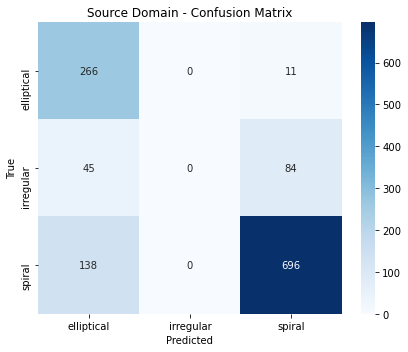

Evaluating Target Domain: 100%|██████████| 32/32 [00:10<00:00,  3.07it/s]
/n/helmod/apps/centos7/Core/Anaconda3/2021.05-jupyterood-fasrc01/x/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/n/helmod/apps/centos7/Core/Anaconda3/2021.05-jupyterood-fasrc01/x/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/n/helmod/apps/centos7/Core/Anaconda3/2021.05-jupyterood-fasrc01/x/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-de


=== Evaluation on Target Domain ===
Accuracy: 38.80%

Classification Report:
              precision    recall  f1-score   support

  elliptical       0.93      0.02      0.04       593
   irregular       0.00      0.00      0.00        31
      spiral       0.38      1.00      0.55       376

    accuracy                           0.39      1000
   macro avg       0.44      0.34      0.20      1000
weighted avg       0.69      0.39      0.23      1000



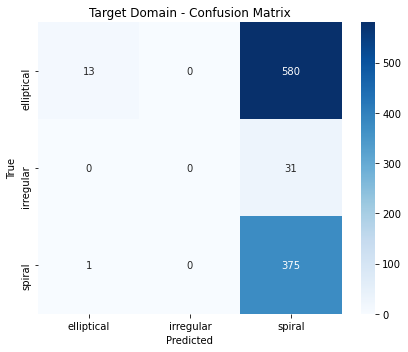

In [99]:
source_model.eval()
source_model.to(device)

# Evaluate on source domain
evaluate_model(source_model, val_loader_source, dataset_source.idx2label, device, name="Source Domain")

# Evaluate on target domain
evaluate_model(source_model, val_loader_target, dataset_target.idx2label, device, name="Target Domain")

> #### 10. Testing different adaptation losses

> #### 10.1 No Adaptation, baseline

In [ ]:
from training_with_logging import train_with_lambda_logging
from plotting_alignment import plot_training_and_alignment, plot_per_class_recalls, plot_embeddings
from metrics_alignment import compute_epoch_metrics
from training_with_logging import train_with_lambda_logging
from save_runs import save_end_of_run

label2idx, idx2label = give_labels()
class_names = tuple([c for c,_ in sorted(label2idx.items(), key=lambda kv: kv[1])])  # ('elliptical','irregular','spiral')

# Model & optimizer constructors
model_ctor     = lambda: CNN(num_classes=len(class_names)).to(device)
optimizer_ctor = lambda params: torch.optim.AdamW(params, lr=1e-3, weight_decay=1e-4)

# ---- Run the four methods (things to be varied: lambdas/blur/epochs) ----
dfs = []

# 0) No Adapt (baseline)
df_no, model_no = train_with_lambda_logging(
    lambda_val=0.0, method_name="NoAdapt",
    model_ctor=model_ctor, optimizer_ctor=optimizer_ctor,
    train_loader_source=train_loader_source, train_loader_target=train_loader_target,
    eval_loader_source=val_loader_source, eval_loader_target=val_loader_target,
    device=device, num_epochs=10, blur=0.75, class_names=class_names
)

save_end_of_run(df_no, model_no, "NoAdapt", 0.0)
dfs.append(df_no)

> #### 10.2 MMD

In [ ]:
# 1) MMD (energy distance in training; MMD^2 computed in diagnostics)
df_mmd, model_mmd = train_with_lambda_logging(
    lambda_val=0.1, method_name="MMD",
    model_ctor=model_ctor, optimizer_ctor=optimizer_ctor,
    train_loader_source=train_loader_source, train_loader_target=train_loader_target,
    eval_loader_source=val_loader_source, eval_loader_target=val_loader_target,
    device=device, num_epochs=10, blur=0.05, class_names=class_names
)

save_end_of_run(df_mmd, model_mmd, "MMD", 0.1)
dfs.append(df_mmd)

> #### 10.3 Sinkhorn (OT)

In [ ]:
# 2) Sinkhorn (OT)
df_sk, model_sk = train_with_lambda_logging(
    lambda_val=0.1, method_name="Sinkhorn",
    model_ctor=model_ctor, optimizer_ctor=optimizer_ctor,
    train_loader_source=train_loader_source, train_loader_target=train_loader_target,
    eval_loader_source=val_loader_source, eval_loader_target=val_loader_target,
    device=device, num_epochs=10, blur=0.05, class_names=class_names
)

save_end_of_run(df_sk, model_sk, "Sinkhorn", 0.1)
dfs.append(df_sk)

> #### 10.4 DANN (adversarial)

In [ ]:
# 3) DANN (adversarial)
df_dann, model_dann = train_with_lambda_logging(
    lambda_val=0.1, method_name="DANN",
    model_ctor=model_ctor, optimizer_ctor=optimizer_ctor,
    train_loader_source=train_loader_source, train_loader_target=train_loader_target,
    eval_loader_source=val_loader_source, eval_loader_target=val_loader_target,
    device=device, num_epochs=10, blur=0.05, class_names=class_names
)

save_end_of_run(df_dann, model_dann, "DANN", 0.1)
dfs.append(df_dann)

In [ ]:
all_dfs = pd.concat(dfs, ignore_index=True)
all_dfs.to_csv("logs/all_methods_metrics.csv", index=False)
print("Saved combined metrics → logs/all_methods_metrics.csv")

> #### 10.5 Plot each technique

In [ ]:
plot_training_and_alignment(df_all, class_names=class_names, savepath="fig_training_alignment.pdf")
plot_per_class_recalls(df_all, class_names=class_names, savepath="fig_perclass.pdf")

embeds = {
    "NoAdapt":  compute_epoch_metrics(model_no,   val_loader_source, val_loader_target, device=device, class_names=class_names)["embed"],
    "MMD":      compute_epoch_metrics(model_mmd,  val_loader_source, val_loader_target, device=device, class_names=class_names)["embed"],
    "Sinkhorn": compute_epoch_metrics(model_sk,   val_loader_source, val_loader_target, device=device, class_names=class_names)["embed"],
    "DANN":     compute_epoch_metrics(model_dann, val_loader_source, val_loader_target, device=device, class_names=class_names)["embed"],
}
plot_embeddings(embeds, savepath="fig_embeddings.pdf", class_names=class_names)